In [7]:
import numpy as np
import networkx as nx
import plotly.graph_objects as go
import webbrowser
import os
import pandas as pd
import random
import string
import statistics
from src import create_fake_patients, whole_model_demographics_gradcam, graph_plot, plot_feature_value
from tensorflow import keras
import tensorflow as tf
from csv import writer
import seaborn as sns
import matplotlib.pyplot as plt
print("tensorflow version:", tf. __version__)
tf.config.list_physical_devices()

second_TGCNN_layer = True
demo = True

include_drugs = False
max_timesteps=100

run_name='hip_1999_to_one_year_advance_model'
years_in_advance = "5"

if include_drugs:
    max_event_codes = 518
else:
    max_event_codes = 512
hip_or_knee = 'hip'



model = whole_model_demographics_gradcam.TGCNN_Model(num_filters=16, num_nodes=max_event_codes, num_time_steps=max_timesteps, 
                            filter_size=4, variable_gamma=True, 
                            exponential_scaling=True, dropout_rate=0.7, lstm_units=64,
                            fcl1_units=128, LSTM_ablation=False, stride=1, activation_type='LeakyReLU', 
                            no_timestamp=False, second_TGCNN_layer=second_TGCNN_layer, num_labels=1)
model.load_weights('hip_1999_to_one_year_advance_model1_CNN_layer')

tensorflow version: 2.10.1
normalised gamma [[-0.08209284]]
normalised gamma [[0.02680662]]


In [8]:
# Generate individual data for the model

input_3d, input_4d, demo_tensor, outcome, outcome_bin = create_fake_patients.return_fake_pat(2, 99, 518, 'hip', 0)


dense_tensor = tf.sparse.to_dense(input_3d)
dense_tensor= tf.transpose(dense_tensor, perm=[2, 1, 0])
dense_tensor = np.flip(dense_tensor, axis=0)
logits = model(input_4d, demo_tensor, training=False)

grads = model.dy_du_branch1
print(grads.shape)

(1, 16, 97)


### Plot the feature mapss

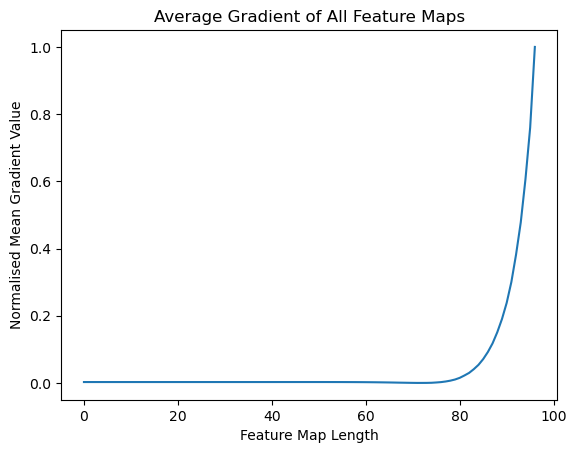

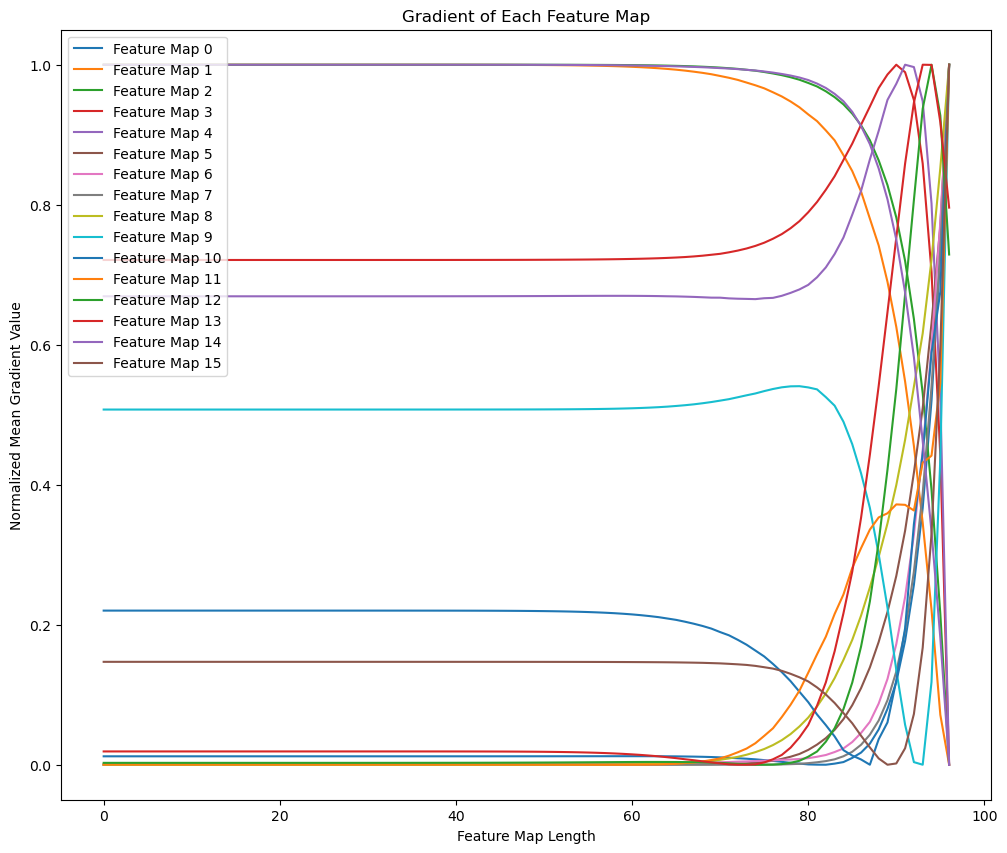

In [21]:
# Branch 1

norm_features = plot_feature_value.plot_ave_grad_all_f_maps(grads)

plot_feature_value.plot_indv_grad_f_maps(grads)

### Plotly/NetworkX Grad-CAM graph

In [13]:
# Get the entire patient's history in a DataFrame
edges_df = graph_plot.create_edges_df_gc(dense_tensor)

# Get the node positions for the graph
pos_df = graph_plot.create_position_df_gc(edges_df)
pos_list = graph_plot.generate_pos_sequence(pos_df['max_codes_per_visit'].max())
pos_df = graph_plot.map_y_coord_to_node(pos_df, pos_list)

In [20]:
# Get the average gradient value per timestep

def generate_filt_sequences(stride, filter_size, feature_map_size):
    sequences = []

    for t in range(feature_map_size):
        start_idx = t * stride + 1
        
        end_idx = start_idx + filter_size
        
        # Generate the list of indices for this timestep
        indices = list(range(start_idx, end_idx))
        
        # Append to sequences
        sequences.append(indices)
    
    return sequences

stride = 1
filter_size = 4

# Global average pooling to get the weight for each filter

f_map_branch1 = tf.squeeze(model.f_map_branch1)

grads_2D = tf.squeeze(grads)
grads_2D = np.array(grads_2D)
#print(grads_2D.shape) # filters, k_size

alphak_lst = [] # alpha value for each filter
k_size = f_map_branch1.shape[1] # number of filters
for filt in range(f_map_branch1.shape[0]):
    filt_grad_sum = tf.reduce_sum(f_map_branch1, axis=1)[filt]
    alpha_k = (1/k_size)*filt_grad_sum
    alphak_lst.append(float(alpha_k))


# Get 1D localisation map

alphak_tf = tf.constant(alphak_lst, dtype=tf.float32)

alphak_tf = tf.reshape(alphak_tf, (-1, 1))

weighted_f_maps = alphak_tf*f_map_branch1
weighted_f_map = tf.reduce_sum(weighted_f_maps, axis=0)


# ReLU as we only are interested in the features that have a positive influence of the class of interest
l_map = np.array(tf.nn.relu(weighted_f_map))
l_map


array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 1.3723331e-05, 3.2643657e-05, 8.7984867e-05,
       1.6199592e-04, 6.6648863e-06, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 1.9548363e-04, 0.0000000e

In [15]:
# Calculating the average gradient per timestep

sequences = generate_filt_sequences(stride, filter_size, l_map.shape[0]+1)

def find_indices_of_value(list_of_lists, value):
    # find the indices of lists containing the value
    return [index for index, sublist in enumerate(list_of_lists) if value in sublist]


f_map_indices = []
for f in range(1, max_timesteps+1): 
    f_map_indices.append(find_indices_of_value(sequences, f))

#len(range(1, l_map.shape[0]+1))
timestep_ave_grad_df = pd.DataFrame({
                        'timestep': list(range(max_timesteps, 0, -1)), 
                        'f_map_indices' : f_map_indices 
                                     })

index_values = timestep_ave_grad_df['f_map_indices'].values

timestep_ave_grads_lst = []
for index, row in timestep_ave_grad_df.iterrows():
    grad_lst_per_timestep = []
    for i in range(0, len(row['f_map_indices'])):
        grad_lst_per_timestep.append(l_map[i])
    # get the mean of the l_map for each time_step
    timestep_ave_grads_lst.append(statistics.mean(grad_lst_per_timestep))

timestep_ave_grad_df['timestep_ave_grad'] = timestep_ave_grads_lst


# this is the gradient per timestep but not all of the patients will have all the timesteps covered so need to take the top x rows (most recent)
# flip these to have the same order as node occurence


timestep_ave_grad_df['x'] = timestep_ave_grad_df['timestep']

# nodes in position x = 0 is the same as nodes in position x = 1 so can just duplicate the value here
new_row_dup = {'timestep': 0, 'f_map_indices': timestep_ave_grad_df['f_map_indices'].iloc[-1], 'timestep_ave_grad': timestep_ave_grad_df['timestep_ave_grad'].iloc[-1], 'x':0}


timestep_ave_grad_df.loc[len(timestep_ave_grad_df)] = new_row_dup
timestep_ave_grad_df


,timestep,f_map_indices,timestep_ave_grad,x
0,100,[0],0.0,100
1,99,"[0, 1]",0.0,99
2,98,"[0, 1, 2]",0.0,98
3,97,"[0, 1, 2, 3]",0.0,97
4,96,"[1, 2, 3, 4]",0.0,96
...,...,...,...,...
96,4,"[93, 94, 95, 96]",0.0,4
97,3,"[94, 95, 96, 97]",0.0,3
98,2,"[95, 96, 97]",0.0,2
99,1,"[96, 97]",0.0,1


In [16]:
# fake mapping dataframe for the ReadCodes and the corresponding descriptions
read_code_map_df = pd.read_csv('fake_read_code_descriptions.csv')

In [17]:
# Extract the numeric part from the 'node' column in pos_df
pos_df['node_num'] = pos_df['node'].str.extract('(\d+)').astype(int)

merged_pos_df = pos_df.merge(read_code_map_df, on='node_num', how='left')

# merge the x cols in timestep_ave_grad_df with merged_pos_df x col to assign grad strength to nodes
merged_pos_df = merged_pos_df.merge(timestep_ave_grad_df, on='x', how='left')

# normalise (min-max) the timestep_ave_grad column (needed as not all of the timesteps are used and should give better y axis values)
merged_pos_df['norm_timestep_ave_grad'] = (merged_pos_df['timestep_ave_grad'] - merged_pos_df['timestep_ave_grad'].min()) / (merged_pos_df['timestep_ave_grad'].max() - merged_pos_df['timestep_ave_grad'].min())

merged_pos_df.head()

,node,x,cumulative_count,max_codes_per_visit,y,node_num,ReadCode,ReadCode_descript,timestep,f_map_indices,timestep_ave_grad,norm_timestep_ave_grad
0,320_v0,0,0,1,0,320,THNCA,320 ReadCode descript here,0,"[96, 97]",0.0,NaN
1,318_v1,1,0,1,0,318,Bisdk,318 ReadCode descript here,1,"[96, 97]",0.0,NaN
2,34_v2,2,0,1,0,34,wBmyX,34 ReadCode descript here,2,"[95, 96, 97]",0.0,NaN
3,201_v3,3,0,1,0,201,Lnljw,201 ReadCode descript here,3,"[94, 95, 96, 97]",0.0,NaN
4,111_v4,4,0,1,0,111,NkDWe,111 ReadCode descript here,4,"[93, 94, 95, 96]",0.0,NaN


In [18]:
# edges_df merge to pos_df to get x0 and x1 and y0 and y1 for edges

# merge edges_df with pos_df on start_node to get x0 and y0
edge_pos_df = edges_df.merge(pos_df, how='left', left_on='start_node', right_on='node')
edge_pos_df = edge_pos_df.rename(columns={'x': 'x0', 'y': 'y0'}).drop(columns=['node', 'cumulative_count', 'max_codes_per_visit'])

# merge the result with pos_df again on end_node to get x1 and y1
edge_pos_df = edge_pos_df.merge(pos_df, how='left', left_on='end_node', right_on='node')
edge_pos_df = edge_pos_df.rename(columns={'x': 'x1', 'y': 'y1'}).drop(columns=['node', 'cumulative_count', 'max_codes_per_visit'])
edge_pos_df.head()

,start_node,end_node,time_between,x0,y0,node_num_x,x1,y1,node_num_y
0,320_v0,318_v1,0.4552,0,0,320,1,0,318
1,318_v1,34_v2,0.5679,1,0,318,2,0,34
2,34_v2,201_v3,0.8325,2,0,34,3,0,201
3,201_v3,111_v4,0.6321,3,0,201,4,0,111
4,111_v4,337_v5,0.0870,4,0,111,5,0,337


In [19]:
# Generate edge_x and edge_y
edge_x = []
edge_y = []

for _, row in edge_pos_df.iterrows():
    edge_x.extend([row['x0'], row['x1'], None])
    edge_y.extend([row['y0'], row['y1'], None])

# Create edge_trace
edge_trace = go.Scatter(
    x=edge_x,
    y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',  # Disable hover info for lines
    mode='lines'
)

# Generate node_x and node_y lists
node_x = pos_df['x'].tolist()
node_y = pos_df['y'].tolist()
node_labels = merged_pos_df['ReadCode'].tolist()
node_hover_text = merged_pos_df['ReadCode_descript'].tolist()


# Map the text colour based on the colour of the node so that it can be read
def text_color_mapping(numbers):
    return ['black' if num < 0.5 else 'white' for num in numbers]

text_colors = text_color_mapping(merged_pos_df['timestep_ave_grad'].to_list())

# Create node_trace with static labels and hover text
node_trace = go.Scatter(
    x=node_x,
    y=node_y,
    mode='markers+text',
    text=node_labels,  # Static labels for nodes
    textposition='middle center', 
    textfont=dict(
        size=10,
        color=text_colors  # Set color for edge text
    ),
    hoverinfo='text',  # Configure hover info
    marker=dict(
        showscale=True,
        colorscale='Viridis',
        reversescale=True,
        color='black',
        size=45,
        colorbar=dict(
            thickness=15,
            title='Influence Visit Had on Prediction (Gradient)',
            xanchor='left',
            titleside='right'
        ),
        line_width=2
    ),
    # Add hover text as a separate trace if needed
    hovertext=node_hover_text
)

node_trace.marker.color = merged_pos_df['timestep_ave_grad'].to_list() # colour the markers based on the number of node connections


# Calculate midpoints for annotations (optional)
annotations = []
for _, row in edge_pos_df.iterrows():
    mid_x = (row['x0'] + row['x1']) / 2
    mid_y = (row['y0'] + row['y1']) / 2
    annotations.append(
        dict(
            x=mid_x,
            y=mid_y,
            text=f"{int(round(row['time_between']*30.4167,0))} days",
            showarrow=False,
            font=dict(size=10),
            align="center"
        )
    )

if outcome == 'hip':
    out_print = f'Patient will likely need a hip replacement in {years_in_advance} years time.'
else:
    out_print = f'It is unlikely this patient will need a hip replacement in {years_in_advance} years time.'
stream_num = '1'

proba_of_replace = 1/ (1+np.exp(logits)) # use sigmoid to convert logits to probs
annotations.append(dict(
                    text=f"The probability of this patient needing a replacement is {round(proba_of_replace.item()*100,2)}%. {out_print}",
                    showarrow=False,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.002 ))

# Create the figure
fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    title=f'Graph Visualisation of Patients Pathway and Connections Associated to Hip Replacement - Stream {stream_num}.',
                    titlefont_size=16,
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=20, l=10, r=5, t=50),
                    annotations=annotations,
                    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )

if ((proba_of_replace.item() > 0.5) and (outcome != 'hip')) or ((proba_of_replace.item()) < 0.5) and (outcome == 'hip'):
    print("Model predicted incorrectly")

fig.show()

Model predicted incorrectly
